# Image Classification with ResNet18

This notebook implements an image classification model using transfer learning with ResNet18。

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import time
import os
import platform
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, as_completed
import multiprocessing

## 1. Hardware Acceleration Configuration

## Configuration and Hardware Setup

This section configures the training parameters and automatically detects the best available hardware acceleration (CUDA GPU > Apple Silicon MPS > CPU). It also sets random seeds for reproducible results.

Key settings include:
- **Batch size**: Number of images processed simultaneously
- **Learning rate**: Step size for optimizer updates
- **Number of epochs**: Maximum training iterations
- **Early stopping patience**: Epochs to wait before stopping if no improvement
- **Dataset split**: 70% training, 15% validation, 15% testing

In [16]:
# Configuration settings
CONFIG = {
    'data_dir': '../preprocessed_Public',  # Path to preprocessed data (already split into train/val/test)
    'train_data_dir': '../preprocessed_Public/train',
    'val_data_dir': '../preprocessed_Public/val',
    'test_data_dir': '../preprocessed_Public/test',
    'batch_size': 64,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'num_classes': 3,  # Adjust based on your classes (aluminium, paper, plastic)
    'early_stop_patience': 5,
}

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 自动检测设备优先级: CUDA > MPS > CPU
if torch.cuda.is_available():
    CONFIG['device'] = torch.device("cuda")
    print(f"🚀 Success! Using CUDA GPU acceleration.")
elif torch.backends.mps.is_available():
    CONFIG['device'] = torch.device("mps")
    print(f"🚀 Success! Using Apple M4 GPU (MPS) acceleration.")
else:
    CONFIG['device'] = torch.device("cpu")
    print("⚠️ Warning: No GPU available. Using CPU (Slower).")

⚠️ Warning: No GPU available. Using CPU (Slower).


In [17]:
# 0. Data Cleaning - SKIPPED
# The preprocessed data is already clean and properly formatted.
# No data cleaning needed since images are from preprocessed_Public directory.

print("✅ Using preprocessed data - No data cleaning required!")

✅ Using preprocessed data - No data cleaning required!


In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Standard ResNet18 input size
        transforms.RandomHorizontalFlip(),  # Data augmentation: horizontal mirroring
        transforms.RandomRotation(15),  # Data augmentation: random rotation ±15 degrees
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Color augmentation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Geometric augmentation
        transforms.ToTensor(),  # Convert PIL images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet normalization
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # Consistent size for evaluation
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Same normalization as training
    ]),
}

# Load pre-split datasets (train/val/test already separated)
try:
    # Load each dataset directly from its respective folder
    train_dataset = datasets.ImageFolder(CONFIG['train_data_dir'], transform=data_transforms['train'])
    val_dataset = datasets.ImageFolder(CONFIG['val_data_dir'], transform=data_transforms['val'])
    test_dataset = datasets.ImageFolder(CONFIG['test_data_dir'], transform=data_transforms['val'])
    
    # Extract class names from folder structure
    class_names = train_dataset.classes
    print(f"✅ Classes found: {class_names}")
    
    # Auto-correct num_classes if it doesn't match detected classes
    if len(class_names) != CONFIG['num_classes']:
        print(f"⚠️ WARNING: You set num_classes={CONFIG['num_classes']}, but found {len(class_names)} classes!")
        CONFIG['num_classes'] = len(class_names)  # Auto-correct
    
    # Get dataset sizes
    train_size = len(train_dataset)
    val_size = len(val_dataset)
    test_size = len(test_dataset)
    
    # Configure DataLoader with performance optimizations
    num_workers = 4  # Parallel data loading workers
    use_pin_memory = CONFIG.get('device', torch.device('cpu')).type in ['cuda', 'mps']  # GPU memory pinning
    
    dataloaders = {
        'train': DataLoader(
            train_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=True,  # Shuffle training data
            num_workers=num_workers,
            pin_memory=use_pin_memory,  # Faster GPU transfers
            persistent_workers=(num_workers > 0)  # Keep workers alive between epochs
        ),
        'val': DataLoader(
            val_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,  # No shuffling for validation
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        ),
        'test': DataLoader(
            test_dataset,
            batch_size=CONFIG['batch_size'],
            shuffle=False,  # No shuffling for testing
            num_workers=num_workers,
            pin_memory=use_pin_memory,
            persistent_workers=(num_workers > 0)
        )
    }
    
    # Store dataset sizes for logging
    dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}
    print(f"✅ Dataset split: Train={train_size}, Val={val_size}, Test={test_size}")
    
except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("Please ensure your preprocessed data is in: ../preprocessed_Public/train/, ../preprocessed_Public/val/, ../preprocessed_Public/test/")
    print("Each subdirectory should have class folders (aluminium/, paper/, plastic/)")
    import traceback
    traceback.print_exc()

✅ Classes found: ['aluminium', 'paper', 'plastic']
✅ Dataset split: Train=7512, Val=403, Test=403


## 3. Model Definition (ResNet18 with Transfer Learning)

This section implements transfer learning using a pre-trained ResNet18 model:

### Transfer Learning Strategy
- **Pre-trained weights**: Uses ImageNet-trained ResNet18 for feature extraction
- **Frozen layers**: All convolutional layers are frozen to preserve learned features
- **Custom classifier**: Replaces the final fully connected layer with a custom head
- **Regularization**: Adds dropout (50%) to prevent overfitting on the new classification task

### Model Components
- **Backbone**: ResNet18 feature extractor (512-dimensional output)
- **Classifier head**: Dropout → Linear layer (512 → num_classes)
- **Loss function**: Cross-entropy loss for multi-class classification
- **Optimizer**: Adam optimizer for efficient gradient updates

In [19]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Load pre-trained ResNet18

# Freeze all layers except the final classifier to preserve learned features
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer with custom architecture
num_ftrs = model.fc.in_features  # Get input features from ResNet18 (512)
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # Dropout for regularization to prevent overfitting
    nn.Linear(num_ftrs, CONFIG['num_classes'])  # Final classification layer
)

# Move model to the detected device (GPU/CPU)
model = model.to(CONFIG['device'])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Standard loss for multi-class classification
optimizer = optim.Adam(model.fc.parameters(), lr=CONFIG['learning_rate'])  # Only optimize classifier parameters

## 4. Training Function

## Training Loop with Advanced Features

This section implements a comprehensive training pipeline with multiple optimization techniques:

### Training Features
- **Mixed Precision Training**: Uses automatic mixed precision (AMP) on CUDA GPUs for 1.5-2x speedup and memory efficiency
- **Early Stopping**: Monitors validation accuracy and stops training if no improvement for specified epochs
- **Progress Monitoring**: Displays batch-level and epoch-level metrics during training
- **Best Model Checkpointing**: Automatically saves the model weights with best validation performance

### Training Process
1. **Epoch Loop**: Iterates through specified number of epochs
2. **Phase Loop**: Alternates between training and validation phases
3. **Batch Processing**: Processes data in batches with GPU acceleration
4. **Metrics Calculation**: Computes loss and accuracy for each batch and epoch
5. **Early Stopping Check**: Evaluates validation performance and triggers early stopping if needed

### Memory Management
- **CUDA Cache Clearing**: Automatically clears GPU memory before and after training
- **Memory Monitoring**: Displays GPU memory usage information when available

In [20]:
def train_model(model, criterion, optimizer, num_epochs=5, patience=3):
    """
    Comprehensive training function with early stopping, mixed precision, and progress tracking.
    
    Args:
        model: PyTorch model to train
        criterion: Loss function
        optimizer: Optimizer for parameter updates
        num_epochs: Maximum number of training epochs
        patience: Number of epochs to wait for improvement before early stopping
    
    Returns:
        model: Trained model with best weights loaded
        history: Dictionary containing training/validation metrics per epoch
    """
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
    
    # Early stopping initialization
    best_val_acc = 0.0
    best_model_wts = None
    patience_counter = 0

    # Mixed precision training setup (only for CUDA GPUs)
    scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None
    
    # Clear GPU cache before training to ensure clean memory state
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        print(f'\n{"="*60}')
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'{"="*60}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Enable dropout and batch normalization updates
                print(f'\n🔄 Training Phase')
            else:
                model.eval()   # Disable dropout and use running stats for batch norm
                print(f'\n✅ Validation Phase')

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            batch_count = 0

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                # Move data to the appropriate device (GPU/CPU)
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device'])

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if scaler and phase == 'train':  # Mixed precision training for CUDA
                        with torch.cuda.amp.autocast():
                            outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)
                        # Scale loss and backpropagate
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:  # Standard precision training
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                # Accumulate metrics across batches
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
                batch_count += 1
                
                # Progress reporting every 5 batches
                if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                    batch_acc = torch.sum(preds == labels.data).float() / inputs.size(0)
                    batch_loss = loss.item()
                    print(f'  Batch [{batch_idx+1}/{len(dataloaders[phase])}] | '
                          f'Loss: {batch_loss:.4f} | Acc: {batch_acc:.4f}')

            # Calculate epoch-level metrics
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.float() / total_samples

            print(f'\n{phase.upper()} Results:')
            print(f'  Loss: {epoch_loss:.4f}')
            print(f'  Accuracy: {epoch_acc:.4f}')
            print(f'  Total Samples: {total_samples}')
            
            # Store metrics in history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Early stopping logic based on validation accuracy
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = model.state_dict().copy()
                    patience_counter = 0
                    print(f'\n✅ New best model! Val Acc: {best_val_acc:.4f}')
                else:
                    patience_counter += 1
                    print(f'\n⏳ No improvement for {patience_counter}/{patience} epochs')
                    
                    if patience_counter >= patience:
                        print(f'\n{"="*60}')
                        print(f'🛑 Early Stopping triggered!')
                        print(f'   Best Val Acc: {best_val_acc:.4f}')
                        print(f'   Stopped at Epoch {epoch+1}/{num_epochs}')
                        print(f'{"="*60}')
                        model.load_state_dict(best_model_wts)
                        time_elapsed = time.time() - since
                        print(f'⏱️  Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
                        return model, history

    # Load best model weights if training completed without early stopping
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f'\n{"="*60}')
        print(f'✅ Training finished!')
        print(f'   Best Val Acc: {best_val_acc:.4f}')
        print(f'{"="*60}')
    
    time_elapsed = time.time() - since
    print(f'⏱️  Total training time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Clean up GPU memory after training
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("🧹 CUDA cache cleared after training")
    
    return model, history

In [21]:
# 如果数据加载成功，开始训练
if 'dataloaders' in locals():
    print(f"\n{'='*60}")
    print(f"🚀 Starting ResNet18 Training")
    print(f"{'='*60}")
    print(f"Device: {CONFIG['device']}")
    print(f"Classes: {class_names}")
    print(f"Batch Size: {CONFIG['batch_size']}")
    print(f"Learning Rate: {CONFIG['learning_rate']}")
    print(f"Max Epochs: {CONFIG['num_epochs']}")
    print(f"Early Stop Patience: {CONFIG['early_stop_patience']}")
    print(f"{'='*60}\n")
    
    trained_model, history = train_model(
        model, 
        criterion, 
        optimizer, 
        num_epochs=CONFIG['num_epochs'],
        patience=CONFIG['early_stop_patience']
    )
else:
    print("❌ Data not loaded. Please check the dataset path.")


🚀 Starting ResNet18 Training
Device: cpu
Classes: ['aluminium', 'paper', 'plastic']
Batch Size: 64
Learning Rate: 0.001
Max Epochs: 10
Early Stop Patience: 5


Epoch 1/10

🔄 Training Phase
  Batch [1/118] | Loss: 1.3455 | Acc: 0.3125
  Batch [5/118] | Loss: 1.0841 | Acc: 0.3906
  Batch [10/118] | Loss: 1.1531 | Acc: 0.4375
  Batch [15/118] | Loss: 1.0888 | Acc: 0.4375
  Batch [20/118] | Loss: 0.9097 | Acc: 0.5938
  Batch [25/118] | Loss: 0.9113 | Acc: 0.5312
  Batch [30/118] | Loss: 0.8871 | Acc: 0.5781
  Batch [35/118] | Loss: 0.8305 | Acc: 0.5781
  Batch [40/118] | Loss: 0.7861 | Acc: 0.7188
  Batch [45/118] | Loss: 0.7167 | Acc: 0.6875
  Batch [50/118] | Loss: 0.8982 | Acc: 0.6250
  Batch [55/118] | Loss: 0.6660 | Acc: 0.7656
  Batch [60/118] | Loss: 0.6552 | Acc: 0.7344
  Batch [65/118] | Loss: 0.8146 | Acc: 0.6250
  Batch [70/118] | Loss: 0.6356 | Acc: 0.7500
  Batch [75/118] | Loss: 0.6985 | Acc: 0.7344
  Batch [80/118] | Loss: 0.6294 | Acc: 0.7344
  Batch [85/118] | Loss: 0.770

In [22]:
# CUDA Memory Monitoring (if using CUDA)
if torch.cuda.is_available():
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB total")
    print(f"CUDA Memory Available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")
    torch.cuda.empty_cache()  # Clear any existing cache

In [23]:
# Save the trained model
if 'trained_model' in locals():
    # Option 1: Save only model weights (lightweight, for inference only)
    model_save_path = 'resnet18_waste_classifier.pth'
    torch.save(trained_model.state_dict(), model_save_path)
    print(f"✅ Model weights saved to '{model_save_path}' (for inference)")
    
    # Option 2: Save full model info (includes config, classes, history for reproducibility)
    model_info = {
        'model_state_dict': trained_model.state_dict(),
        'class_names': class_names,
        'config': CONFIG,
        'best_val_acc': max(history['val_acc']) if 'history' in locals() else None,
        'training_history': history if 'history' in locals() else None
    }
    full_save_path = 'resnet18_waste_classifier_full.pth'
    torch.save(model_info, full_save_path)
    print(f"✅ Full model info saved to '{full_save_path}' (for complete reproducibility)")
    
    print("\n📋 File Differences:")
    print("   - .pth (weights only): Smaller file, for deployment/inference")
    print("   - _full.pth (complete): Larger file, includes config/classes/history")
else:
    print("❌ No trained model to save.")

✅ Model weights saved to 'resnet18_waste_classifier.pth' (for inference)
✅ Full model info saved to 'resnet18_waste_classifier_full.pth' (for complete reproducibility)

📋 File Differences:
   - .pth (weights only): Smaller file, for deployment/inference
   - _full.pth (complete): Larger file, includes config/classes/history


## 6. Visualize Training Results

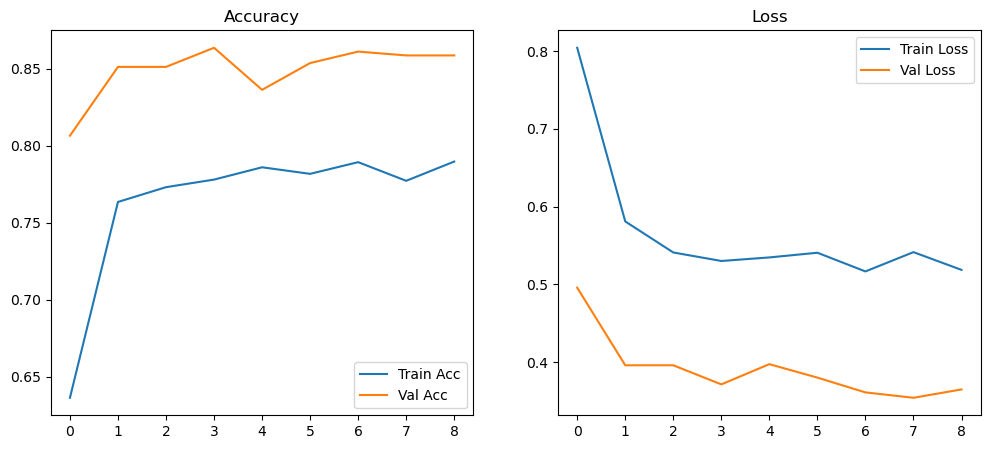

In [24]:
if 'history' in locals():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
else:
    print("❌ No training history available.")

## 7. Confusion Matrix and Classification Report

## Model Evaluation and Performance Analysis

This section provides comprehensive evaluation of the trained model on both validation and test sets:

### Evaluation Metrics
- **Confusion Matrix**: Visual heatmap showing prediction accuracy across all classes
- **Classification Report**: Detailed per-class metrics (precision, recall, F1-score)
- **Overall Accuracy**: Aggregate performance across all predictions
- **Training History**: Visualization of loss and accuracy curves over training epochs

### Evaluation Process
1. **Model Loading**: Loads the best-performing model weights
2. **Inference**: Runs predictions on validation and test sets without gradient computation
3. **Metrics Calculation**: Computes confusion matrix and classification metrics
4. **Visualization**: Creates heatmaps and plots for result interpretation
5. **Results Export**: Saves detailed predictions to CSV files for further analysis

### Output Files
- **predictions_val.csv**: Validation set predictions with true and predicted labels
- **predictions_test.csv**: Test set predictions with true and predicted labels
- **Model files**: Both lightweight (.pth) and full checkpoint (.pth) versions


📊 Evaluating on VAL set


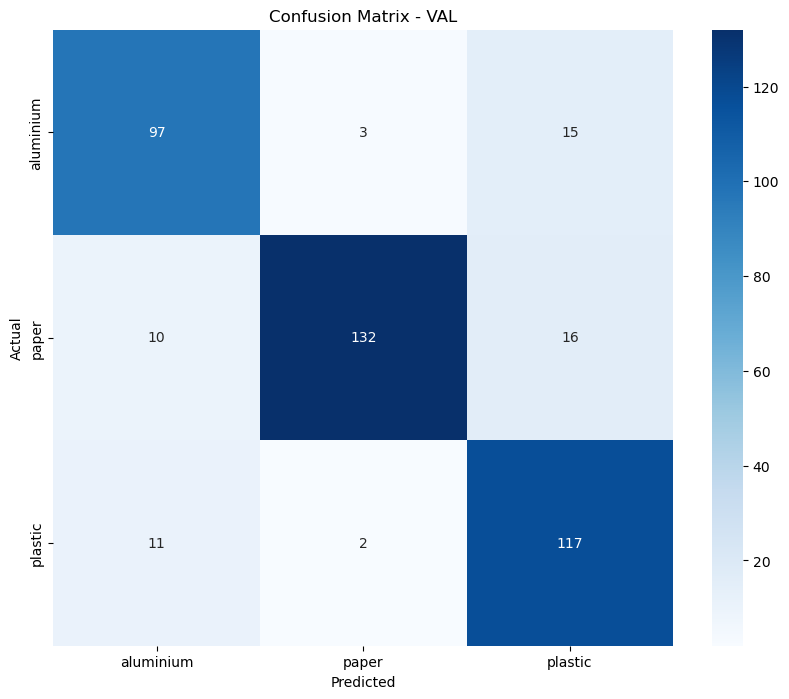


Classification Report (VAL):

              precision    recall  f1-score   support

   aluminium       0.82      0.84      0.83       115
       paper       0.96      0.84      0.89       158
     plastic       0.79      0.90      0.84       130

    accuracy                           0.86       403
   macro avg       0.86      0.86      0.86       403
weighted avg       0.87      0.86      0.86       403

Overall VAL Accuracy: 0.8586
✅ Predictions saved to 'predictions_val.csv'

📊 Evaluating on TEST set


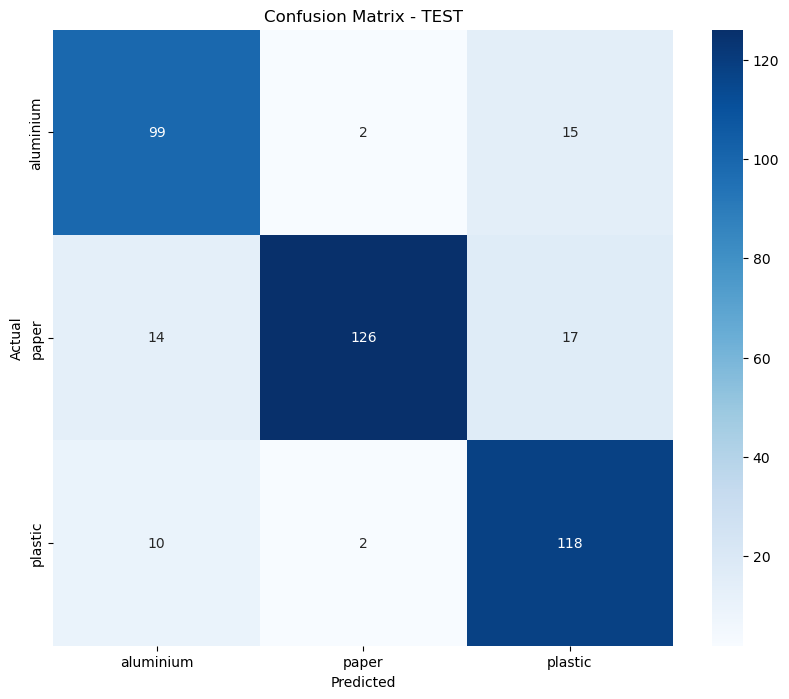


Classification Report (TEST):

              precision    recall  f1-score   support

   aluminium       0.80      0.85      0.83       116
       paper       0.97      0.80      0.88       157
     plastic       0.79      0.91      0.84       130

    accuracy                           0.85       403
   macro avg       0.85      0.85      0.85       403
weighted avg       0.86      0.85      0.85       403

Overall TEST Accuracy: 0.8511
✅ Predictions saved to 'predictions_test.csv'


In [25]:
# Evaluate on both validation and test sets
if 'trained_model' in locals() and 'dataloaders' in locals():
    for phase in ['val', 'test']:
        print(f"\n{'='*60}")
        print(f"📊 Evaluating on {phase.upper()} set")
        print(f"{'='*60}")
        
        all_preds = []
        all_labels = []
        all_filenames = []  # Collect sample identifiers for CSV export
        
        trained_model.eval()  # Set model to evaluation mode (disables dropout/batch norm updates)
        with torch.no_grad():  # Disable gradient computation for inference
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(CONFIG['device'])
                outputs = trained_model(inputs)
                _, preds = torch.max(outputs, 1)  # Get predicted class indices
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # Generate sample identifiers since DataLoader doesn't provide original filenames
                batch_size = inputs.size(0)
                start_idx = len(all_filenames)
                all_filenames.extend([f"{phase}_sample_{start_idx + i}" for i in range(batch_size)])

        # Generate confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title(f'Confusion Matrix - {phase.upper()}')
        plt.show()
        
        # Generate detailed classification report
        print(f"\nClassification Report ({phase.upper()}):\n")
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Calculate overall accuracy
        accuracy = np.trace(cm) / np.sum(cm)
        print(f"Overall {phase.upper()} Accuracy: {accuracy:.4f}")
        
        # Export predictions to CSV for further analysis
        import pandas as pd
        df_predictions = pd.DataFrame({
            'filename': all_filenames,  # Sample identifiers
            'true_label': [class_names[label] for label in all_labels],
            'predicted_label': [class_names[pred] for pred in all_preds]
        })
        df_predictions.to_csv(f'predictions_{phase}.csv', index=False)
        print(f"✅ Predictions saved to 'predictions_{phase}.csv'")
else:
    print("❌ Model not trained or data not loaded.")

Loading from full model checkpoint...
  Classes from checkpoint: ['aluminium', 'paper', 'plastic']
✓ Model loaded from resnet18_waste_classifier_full.pth
✓ Test dataset loaded from ../Dataset/
  Classes: ['aluminium', 'paper', 'plastic']
  Total images: 533

EVALUATING MODEL ON SELF-COLLECTED TEST SET (ResNet18)

✓ Predictions saved to predictions_test.csv

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   aluminium     0.6736    0.6554    0.6644       148
       paper     0.6162    0.4040    0.4880       151
     plastic     0.6241    0.7735    0.6908       234

    accuracy                         0.6360       533
   macro avg     0.6380    0.6110    0.6144       533
weighted avg     0.6356    0.6360    0.6260       533


CONFUSION MATRIX:


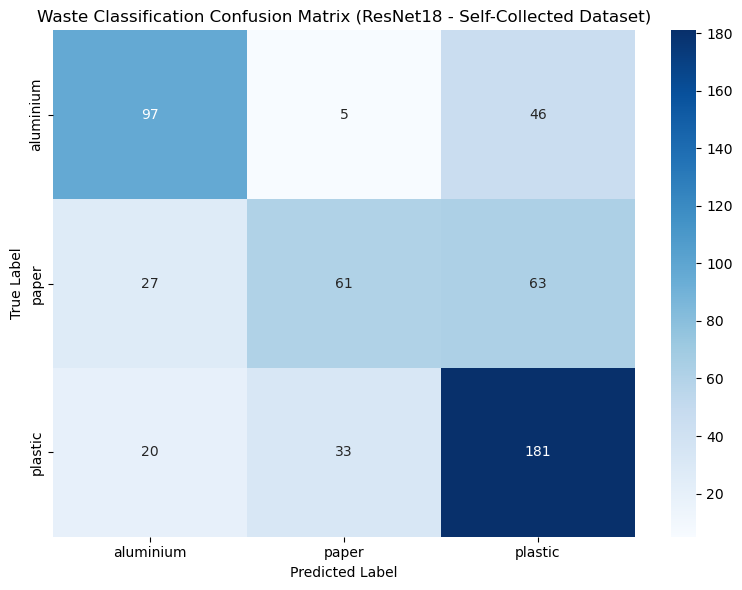


PER-CLASS ACCURACY
  aluminium: 0.6554 (97/148)
  paper: 0.4040 (61/151)
  plastic: 0.7735 (181/234)

✓ Overall Accuracy: 0.6360

Weighted Metrics:
  Precision: 0.6356
  Recall: 0.6360
  F1-Score: 0.6260


In [26]:
# ==========================================
# STANDALONE MODEL EVALUATION CELL
# This cell can run independently without running previous cells
# ==========================================

import torch
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import os
import pandas as pd


# ==========================================
# MODEL EVALUATION & CONFUSION MATRIX
# ==========================================

def evaluate_model(model, dataloader, class_names, device):
    """
    Evaluate the model and return predictions, labels, and metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix'):
    """
    Plot confusion matrix using seaborn heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# ==========================================
# LOAD MODEL & EVALUATE ON TEST SET
# ==========================================

# Configuration
model_path = 'resnet18_waste_classifier_full.pth'
test_data_dir = '../Dataset/'  # Self-collected test dataset
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_CLASSES = 3

# Validation transform (no augmentation for testing)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Standard size for ResNet18
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the trained model
if not os.path.exists(model_path):
    print(f"❌ Model file {model_path} not found!")
    print("Please train the model first by running the training cells above.")
else:
    # Load model (could be full model or state_dict)
    loaded = torch.load(model_path, map_location=DEVICE)
    
    if isinstance(loaded, dict) and 'model_state_dict' in loaded:
        # It's a full save with metadata
        print("Loading from full model checkpoint...")
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features  # 512 for ResNet18
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, NUM_CLASSES)
        )
        model.load_state_dict(loaded['model_state_dict'])
        class_names = loaded.get('class_names', ['aluminium', 'paper', 'plastic'])
        print(f"  Classes from checkpoint: {class_names}")
    elif isinstance(loaded, dict):
        # It's just a state_dict
        print("Loading from state_dict...")
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = model.fc.in_features  # 512 for ResNet18
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, NUM_CLASSES)
        )
        model.load_state_dict(loaded)
    else:
        # It's the full model object
        print("Loading full model...")
        model = loaded
    
    model.to(DEVICE)
    model.eval()
    print(f"✓ Model loaded from {model_path}")

    # Create test dataloader for self-collected dataset
    test_dataset = datasets.ImageFolder(test_data_dir, transform=val_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # Use class names from dataset if not loaded from checkpoint
    if 'class_names' not in locals():
        class_names = test_dataset.classes
    
    print(f"✓ Test dataset loaded from {test_data_dir}")
    print(f"  Classes: {class_names}")
    print(f"  Total images: {len(test_dataset)}")

    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING MODEL ON SELF-COLLECTED TEST SET (ResNet18)")
    print("="*70)
    preds, labels = evaluate_model(model, test_loader, class_names, DEVICE)

    # Save predictions to CSV
    predictions_df = pd.DataFrame({
        'True Label': [class_names[label] for label in labels],
        'Predicted Label': [class_names[pred] for pred in preds]
    })
    predictions_df.to_csv('predictions_test.csv', index=False)
    print("\n✓ Predictions saved to predictions_test.csv")

    # Calculate confusion matrix
    cm = confusion_matrix(labels, preds)

    # Print classification report
    print("\n" + "="*70)
    print("CLASSIFICATION REPORT")
    print("="*70)
    report = classification_report(labels, preds, target_names=class_names, digits=4)
    print(report)

    # Plot confusion matrix
    print("\nCONFUSION MATRIX:")
    plot_confusion_matrix(cm, class_names, title='Waste Classification Confusion Matrix (ResNet18 - Self-Collected Dataset)')

    # Calculate per-class accuracy
    print("\n" + "="*70)
    print("PER-CLASS ACCURACY")
    print("="*70)
    for i, class_name in enumerate(class_names):
        class_accuracy = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() > 0 else 0
        print(f"  {class_name}: {class_accuracy:.4f} ({cm[i, i]}/{cm[i, :].sum()})")

    # Overall accuracy
    overall_accuracy = np.trace(cm) / np.sum(cm)
    print(f"\n✓ Overall Accuracy: {overall_accuracy:.4f}")

    # Additional metrics
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average='weighted')
    print(f"\nWeighted Metrics:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print("="*70)
